# Préparation et Chargement des données 

## 1. Importation des bibliothèques

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import VarianceThreshold, SelectPercentile,f_classif
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score
from sklearn.linear_model import Perceptron, LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.impute import SimpleImputer

## 2. Chargement des datasets 

In [2]:
t_arr = pd.read_csv("in_time.csv")
t_dép = pd.read_csv("out_time.csv")
emp_survey = pd.read_csv("employee_survey_data.csv")
gen_data = pd.read_csv("general_data.csv")
man_survey = pd.read_csv("manager_survey_data.csv")      

## 3. Gestion des valeurs manquantes

### 3.1 Taux de valeurs manquantes

In [3]:
missing_rates = t_arr.isna().mean()
print(missing_rates)

Unnamed: 0    0.000000
2015-01-01    1.000000
2015-01-02    0.047392
2015-01-05    0.046712
2015-01-06    0.051701
                ...   
2015-12-25    1.000000
2015-12-28    0.053061
2015-12-29    0.052154
2015-12-30    0.060091
2015-12-31    0.048299
Length: 262, dtype: float64


In [4]:
missing_rates = t_dép.isnull().mean()
print(missing_rates)

Unnamed: 0    0.000000
2015-01-01    1.000000
2015-01-02    0.047392
2015-01-05    0.046712
2015-01-06    0.051701
                ...   
2015-12-25    1.000000
2015-12-28    0.053061
2015-12-29    0.052154
2015-12-30    0.060091
2015-12-31    0.048299
Length: 262, dtype: float64


In [5]:
missing_rates = gen_data.isnull().mean()
print(missing_rates)

Age                        0.000000
Attrition                  0.000000
BusinessTravel             0.000000
Department                 0.000000
DistanceFromHome           0.000000
Education                  0.000000
EducationField             0.000000
EmployeeCount              0.000000
EmployeeID                 0.000000
Gender                     0.000000
JobLevel                   0.000000
JobRole                    0.000000
MaritalStatus              0.000000
MonthlyIncome              0.000000
NumCompaniesWorked         0.004308
Over18                     0.000000
PercentSalaryHike          0.000000
StandardHours              0.000000
StockOptionLevel           0.000000
TotalWorkingYears          0.002041
TrainingTimesLastYear      0.000000
YearsAtCompany             0.000000
YearsSinceLastPromotion    0.000000
YearsWithCurrManager       0.000000
dtype: float64


In [6]:
print(man_survey.isnull().mean())

EmployeeID           0.0
JobInvolvement       0.0
PerformanceRating    0.0
dtype: float64


In [7]:
print(emp_survey.isnull().mean())

EmployeeID                 0.000000
EnvironmentSatisfaction    0.005669
JobSatisfaction            0.004535
WorkLifeBalance            0.008617
dtype: float64


### 3.2 Nettoyage des données

#### Fonction utilisée pour convertir les durées en minutes

In [8]:
# Fonction pour convertir datetime.time en secondes depuis minuit
def time_to_minutes(time_obj):
    """Convertit un objet datetime.time en secondes depuis minuit."""
    if time_obj is not pd.NaT:  # Vérifie si la valeur n'est pas NaN
        return time_obj.hour * 60 + time_obj.minute * 60 + time_obj.second/60
    return None

#### 3.2.1 Nettoyage du dataset des temps d'arrivée

In [9]:
threshold = 0.9
column_to_drop = missing_rates[missing_rates>= threshold].index
t_arr_cleaned = t_arr.drop(columns=column_to_drop)
t_arr_cleaned = t_arr_cleaned.drop(columns="Unnamed: 0")
t_arr_cleaned.shape

(4410, 261)

In [10]:
# conversion en date time 
t_arr_cleaned.columns = pd.to_datetime(t_arr_cleaned.columns)
t_arr_converted = t_arr_cleaned.apply(pd.to_datetime)
t_arr_converted = t_arr_converted.apply(lambda col: col.dt.time)

# Appliquer la conversion en secondes sur votre DataFrame
t_arr_seconds = t_arr_converted.applymap(lambda x: time_to_minutes(x))
# Calculer la médiane des secondes pour chaque colonne
medians = t_arr_seconds.median()
# Remplacer les valeurs manquantes par la médiane en secondes
t_arr_seconds_filled = t_arr_seconds.apply(lambda col: col.fillna(medians[col.name]))
# Afficher le DataFrame final avec les valeurs manquantes remplies
t_arr_seconds_filled


C:\Users\brago\AppData\Local\Temp\ipykernel_26412\309177983.py:7: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  t_arr_seconds = t_arr_converted.applymap(lambda x: time_to_minutes(x))
C:\Users\brago\AppData\Local\Temp\ipykernel_26412\309177983.py:11: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  t_arr_seconds_filled = t_arr_seconds.apply(lambda col: col.fillna(medians[col.name]))


,2015-01-01,2015-01-02,2015-01-05,2015-01-06,2015-01-07,2015-01-08,2015-01-09,2015-01-12,2015-01-13,2015-01-14,...,2015-12-18,2015-12-21,2015-12-22,2015-12-23,2015-12-24,2015-12-25,2015-12-28,2015-12-29,2015-12-30,2015-12-31
0,NaN,3120.750000,1080.800000,3780.433333,2580.516667,3600.150000,1140.416667,3060.883333,1380.100000,NaN,...,2280.800000,3840.483333,840.100000,1440.450000,1260.583333,NaN,1380.683333,780.600000,3780.200000,1320.733333
1,NaN,1500.733333,1860.083333,2400.383333,3240.283333,1140.066667,3120.433333,600.116667,3180.483333,NaN,...,2820.283333,3480.033333,2580.850000,1320.166667,2340.616667,NaN,2400.750000,3840.816667,2520.416667,2160.333333
2,NaN,1620.683333,3540.833333,1440.216667,3360.450000,780.666667,900.816667,780.783333,1860.433333,NaN,...,1500.233333,1200.466667,3180.733333,1500.900000,1020.433333,NaN,3060.083333,3120.600000,2580.083333,2280.650000
3,NaN,900.100000,3900.533333,1260.116667,2760.500000,720.133333,1080.200000,1380.700000,3720.366667,NaN,...,1620.633333,4020.350000,840.416667,1260.766667,3120.250000,NaN,3660.733333,2520.266667,1680.200000,660.250000
4,NaN,2280.283333,3480.966667,3240.466667,3480.616667,1740.733333,600.833333,2340.450000,4080.533333,NaN,...,4020.583333,780.683333,1200.500000,1380.600000,3180.400000,NaN,900.250000,2400.883333,1620.350000,3000.150000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4405,NaN,1740.533333,1620.883333,2160.850000,960.966667,3240.100000,3480.400000,2760.166667,2040.033333,NaN,...,660.100000,2100.416667,1560.183333,840.666667,3240.666667,NaN,1500.650000,1200.150000,2220.316667,600.200000
4406,NaN,780.683333,2400.475000,3180.000000,3060.166667,600.950000,3180.066667,1020.533333,900.183333,NaN,...,2160.533333,3000.400000,3540.500000,2520.350000,3360.683333,NaN,3780.383333,1380.533333,1860.150000,1140.800000
4407,NaN,660.016667,2520.000000,3480.283333,2280.200000,3360.633333,660.050000,3480.200000,3360.166667,NaN,...,600.950000,3600.116667,720.166667,4020.483333,3900.083333,NaN,4080.400000,2280.516667,720.600000,780.500000
4408,NaN,1620.083333,720.450000,1320.833333,1320.516667,3060.950000,2340.616667,600.633333,3420.050000,NaN,...,3780.550000,660.133333,1200.316667,3060.500000,3900.083333,NaN,3840.416667,3780.700000,1500.733333,3900.783333


####  3.2.2 Nettoyage du dataset des temps de départ

In [11]:
t_dép_cleaned = t_dép.drop(columns= column_to_drop)
t_dép_cleaned = t_dép_cleaned.drop(columns="Unnamed: 0")
t_dép_cleaned.shape

(4410, 261)

In [12]:
# conversion en date time 
t_dép_cleaned.columns = pd.to_datetime(t_dép_cleaned.columns)
t_dép_converted = t_dép_cleaned.apply(pd.to_datetime)
t_dép_converted = t_dép_converted.apply(lambda col: col.dt.time)

# Appliquer la conversion en secondes sur votre DataFrame
t_dép_seconds = t_dép_converted.applymap(lambda x: time_to_minutes(x))
# Calculer la médiane des secondes pour chaque colonne
medians = t_dép_seconds.median()
# Remplacer les valeurs manquantes par la médiane en secondes
t_dép_seconds_filled = t_dép_seconds.apply(lambda col: col.fillna(medians[col.name]))
# Afficher le DataFrame final avec les valeurs manquantes remplies
t_dép_seconds_filled

C:\Users\brago\AppData\Local\Temp\ipykernel_26412\1035543345.py:7: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  t_dép_seconds = t_dép_converted.applymap(lambda x: time_to_minutes(x))
C:\Users\brago\AppData\Local\Temp\ipykernel_26412\1035543345.py:11: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  t_dép_seconds_filled = t_dép_seconds.apply(lambda col: col.fillna(medians[col.name]))


,2015-01-01,2015-01-02,2015-01-05,2015-01-06,2015-01-07,2015-01-08,2015-01-09,2015-01-12,2015-01-13,2015-01-14,...,2015-12-18,2015-12-21,2015-12-22,2015-12-23,2015-12-24,2015-12-25,2015-12-28,2015-12-29,2015-12-30,2015-12-31
0,NaN,4320.250000,2220.183333,2160.083333,3000.916667,1500.533333,3300.483333,4440.650000,1200.966667,NaN,...,2760.700000,1920.833333,2640.850000,3600.733333,3840.366667,NaN,1080.116667,2340.500000,3420.933333,2040.550000
1,NaN,2400.283333,3900.366667,2880.333333,1560.100000,3060.066667,4080.483333,3180.800000,1080.216667,NaN,...,2940.466667,3060.266667,2040.583333,3300.300000,2760.458333,NaN,1500.633333,4260.766667,2940.583333,3420.966667
2,NaN,4500.233333,1380.766667,3240.533333,2940.350000,2460.366667,4380.500000,2700.900000,2280.416667,NaN,...,1140.383333,2220.283333,2880.833333,4500.716667,4440.416667,NaN,3540.516667,1560.933333,1380.416667,1920.833333
3,NaN,2520.400000,1860.050000,1440.700000,2880.666667,4140.183333,2160.783333,1800.616667,1680.750000,NaN,...,4320.383333,3900.150000,2460.000000,3180.583333,3840.350000,NaN,2160.566667,4440.266667,3420.183333,1560.233333
4,NaN,2940.616667,3960.250000,2580.416667,3240.983333,4560.466667,3660.133333,4140.350000,1920.966667,NaN,...,4140.800000,3600.583333,1500.950000,1080.816667,4560.366667,NaN,3660.983333,3900.000000,1920.550000,3540.233333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4405,NaN,2640.616667,1620.333333,4080.816667,4500.666667,4500.516667,1440.250000,4500.800000,1680.583333,NaN,...,1440.083333,3180.100000,3060.733333,3480.933333,2340.483333,NaN,3720.583333,1980.633333,2520.933333,2880.683333
4406,NaN,2100.016667,2820.533333,1320.616667,2400.833333,1680.550000,2460.933333,1560.700000,2280.716667,NaN,...,2280.033333,2760.233333,3600.983333,3240.983333,3720.250000,NaN,2940.566667,3780.033333,1140.283333,2040.650000
4407,NaN,2040.583333,1500.116667,2640.766667,2700.366667,1320.416667,1140.950000,3120.750000,1920.866667,NaN,...,3900.083333,3600.083333,3840.383333,3600.616667,2220.200000,NaN,3600.466667,2820.583333,3900.233333,1560.916667
4408,NaN,4020.616667,3360.666667,1200.133333,3240.983333,4380.216667,2820.383333,2220.283333,2580.033333,NaN,...,4260.733333,2400.583333,3060.666667,4500.000000,3360.950000,NaN,4620.600000,4380.433333,3360.366667,3120.750000


#### 3.2.3 Dataset de durée moyenne de travail de chaque employé 

In [13]:
t_durée = t_dép_seconds_filled - t_arr_seconds_filled
t_durée_mean= t_durée.mean(axis=1)
t_durée_mean = t_durée_mean.to_frame(name="worktime_mean")
t_durée_mean.head()

,worktime_mean
0,326.958434
1,369.942303
2,525.524264
3,353.988788
4,345.297523


#### 3.2.4 Nettoyage du dataset des enquêtes sur les employés

In [14]:
emp_survey = emp_survey.fillna(emp_survey.median())
emp_survey.isna().mean()

EmployeeID                 0.0
EnvironmentSatisfaction    0.0
JobSatisfaction            0.0
WorkLifeBalance            0.0
dtype: float64

#### 3.2.5 Nettoyage du dataset gen_data

In [15]:
print(f"Avant :\n{gen_data.isnull().mean()}\n")
gen_data["NumCompaniesWorked"] = gen_data["NumCompaniesWorked"].fillna(gen_data["NumCompaniesWorked"].median())
gen_data["TotalWorkingYears"] = gen_data["TotalWorkingYears"].fillna(gen_data["TotalWorkingYears"].median())
print(f"Après :\n{gen_data.isnull().mean()}")

Avant :
Age                        0.000000
Attrition                  0.000000
BusinessTravel             0.000000
Department                 0.000000
DistanceFromHome           0.000000
Education                  0.000000
EducationField             0.000000
EmployeeCount              0.000000
EmployeeID                 0.000000
Gender                     0.000000
JobLevel                   0.000000
JobRole                    0.000000
MaritalStatus              0.000000
MonthlyIncome              0.000000
NumCompaniesWorked         0.004308
Over18                     0.000000
PercentSalaryHike          0.000000
StandardHours              0.000000
StockOptionLevel           0.000000
TotalWorkingYears          0.002041
TrainingTimesLastYear      0.000000
YearsAtCompany             0.000000
YearsSinceLastPromotion    0.000000
YearsWithCurrManager       0.000000
dtype: float64

Après :
Age                        0.0
Attrition                  0.0
BusinessTravel             0.0
Department 

#### 3.3 Concatenation du dataset résultant « t_durée » avec gen_data et les data-set surveys

In [16]:
result = pd.concat([gen_data, man_survey, emp_survey,t_durée_mean], axis=1)
result_final = result.loc[:, ~result.columns.duplicated()]
result_final.head()

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeID,Gender,...,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,JobInvolvement,PerformanceRating,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,worktime_mean
0,51,No,Travel_Rarely,Sales,6,2,Life Sciences,1,1,Female,...,6,1,0,0,3,3,3.0,4.0,2.0,326.958434
1,31,Yes,Travel_Frequently,Research & Development,10,1,Life Sciences,1,2,Female,...,3,5,1,4,2,4,3.0,2.0,4.0,369.942303
2,32,No,Travel_Frequently,Research & Development,17,4,Other,1,3,Male,...,2,5,0,3,3,3,2.0,2.0,1.0,525.524264
3,38,No,Non-Travel,Research & Development,2,5,Life Sciences,1,4,Male,...,5,8,7,5,2,3,4.0,4.0,3.0,353.988788
4,32,No,Travel_Rarely,Research & Development,10,1,Medical,1,5,Male,...,2,6,0,4,3,3,4.0,1.0,3.0,345.297523


#### 3.4 Encodage et Normalisation des données

##### 3.4.1 Encodage des données

In [17]:
result_final_cat = result_final[['BusinessTravel','Department','EducationField','Gender','JobRole','MaritalStatus','Over18']]
encoder = OneHotEncoder(sparse_output=False)
result_final_cat_prepared = encoder.fit_transform(result_final_cat)
attrition = pd.DataFrame({
    'Attrition': result_final['Attrition'].replace({'Yes': 1, 'No': 0})
})
result_final_encoded = pd.DataFrame(result_final_cat_prepared, columns=encoder.get_feature_names_out(input_features=result_final_cat.columns))
result_final_encoded.head()

C:\Users\brago\AppData\Local\Temp\ipykernel_26412\4029410223.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  'Attrition': result_final['Attrition'].replace({'Yes': 1, 'No': 0})


,BusinessTravel_Non-Travel,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,Department_Human Resources,Department_Research & Development,Department_Sales,EducationField_Human Resources,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,...,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,Over18_Y
0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0
2,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
4,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0


##### 3.4.2 Normalisation des données 

In [18]:
imputer = SimpleImputer(strategy="median")
result_final_num = result_final.select_dtypes(include=['number'])
scaler = StandardScaler()
result_final_scaled = pd.DataFrame(scaler.fit_transform(result_final_num), columns=result_final_num.columns)
result_final_scaled.head()

,Age,DistanceFromHome,Education,EmployeeCount,EmployeeID,JobLevel,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StandardHours,...,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,JobInvolvement,PerformanceRating,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,worktime_mean
0,1.541369,-0.393938,-0.891688,0.0,-1.731658,-0.961486,1.405136,-0.678464,-1.150554,0.0,...,2.483396,-0.981014,-0.679146,-1.155935,0.379672,-0.426230,0.252200,1.156302,-1.085336,-1.067289
1,-0.648668,0.099639,-1.868426,0.0,-1.730873,-0.961486,-0.491661,-1.079486,2.129306,0.0,...,0.155707,-0.327893,-0.368715,-0.034520,-1.026167,2.346151,0.252200,-0.663899,1.757749,-0.730393
2,-0.539166,0.963398,1.061787,0.0,-1.730087,1.749610,2.725053,-0.678464,-0.057267,0.0,...,-0.620189,-0.327893,-0.679146,-0.314873,0.379672,-0.426230,-0.665460,-0.663899,-2.506879,0.489015
3,0.117845,-0.887515,2.038524,0.0,-1.729302,0.845911,0.386301,0.123580,-1.150554,0.0,...,1.707500,0.161947,1.493867,0.245834,-1.026167,-0.426230,1.169861,1.156302,0.336206,-0.855432
4,-0.539166,0.099639,-1.868426,0.0,-1.728516,-0.961486,-0.884109,0.524602,-0.877232,0.0,...,-0.620189,-0.164613,-0.679146,-0.034520,0.379672,-0.426230,1.169861,-1.573999,0.336206,-0.923552


##### 3.4.3 Dataset final normalisé et encodé 

In [19]:
finalresult = pd.concat([result_final_scaled,result_final_encoded,attrition], axis=1)
finalresult.head()

,Age,DistanceFromHome,Education,EmployeeCount,EmployeeID,JobLevel,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StandardHours,...,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,Over18_Y,Attrition
0,1.541369,-0.393938,-0.891688,0.0,-1.731658,-0.961486,1.405136,-0.678464,-1.150554,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0
1,-0.648668,0.099639,-1.868426,0.0,-1.730873,-0.961486,-0.491661,-1.079486,2.129306,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1
2,-0.539166,0.963398,1.061787,0.0,-1.730087,1.749610,2.725053,-0.678464,-0.057267,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0
3,0.117845,-0.887515,2.038524,0.0,-1.729302,0.845911,0.386301,0.123580,-1.150554,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0
4,-0.539166,0.099639,-1.868426,0.0,-1.728516,-0.961486,-0.884109,0.524602,-0.877232,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0


# Exploration et Visualisation des données 

# 1. Visualisation des variables numériques

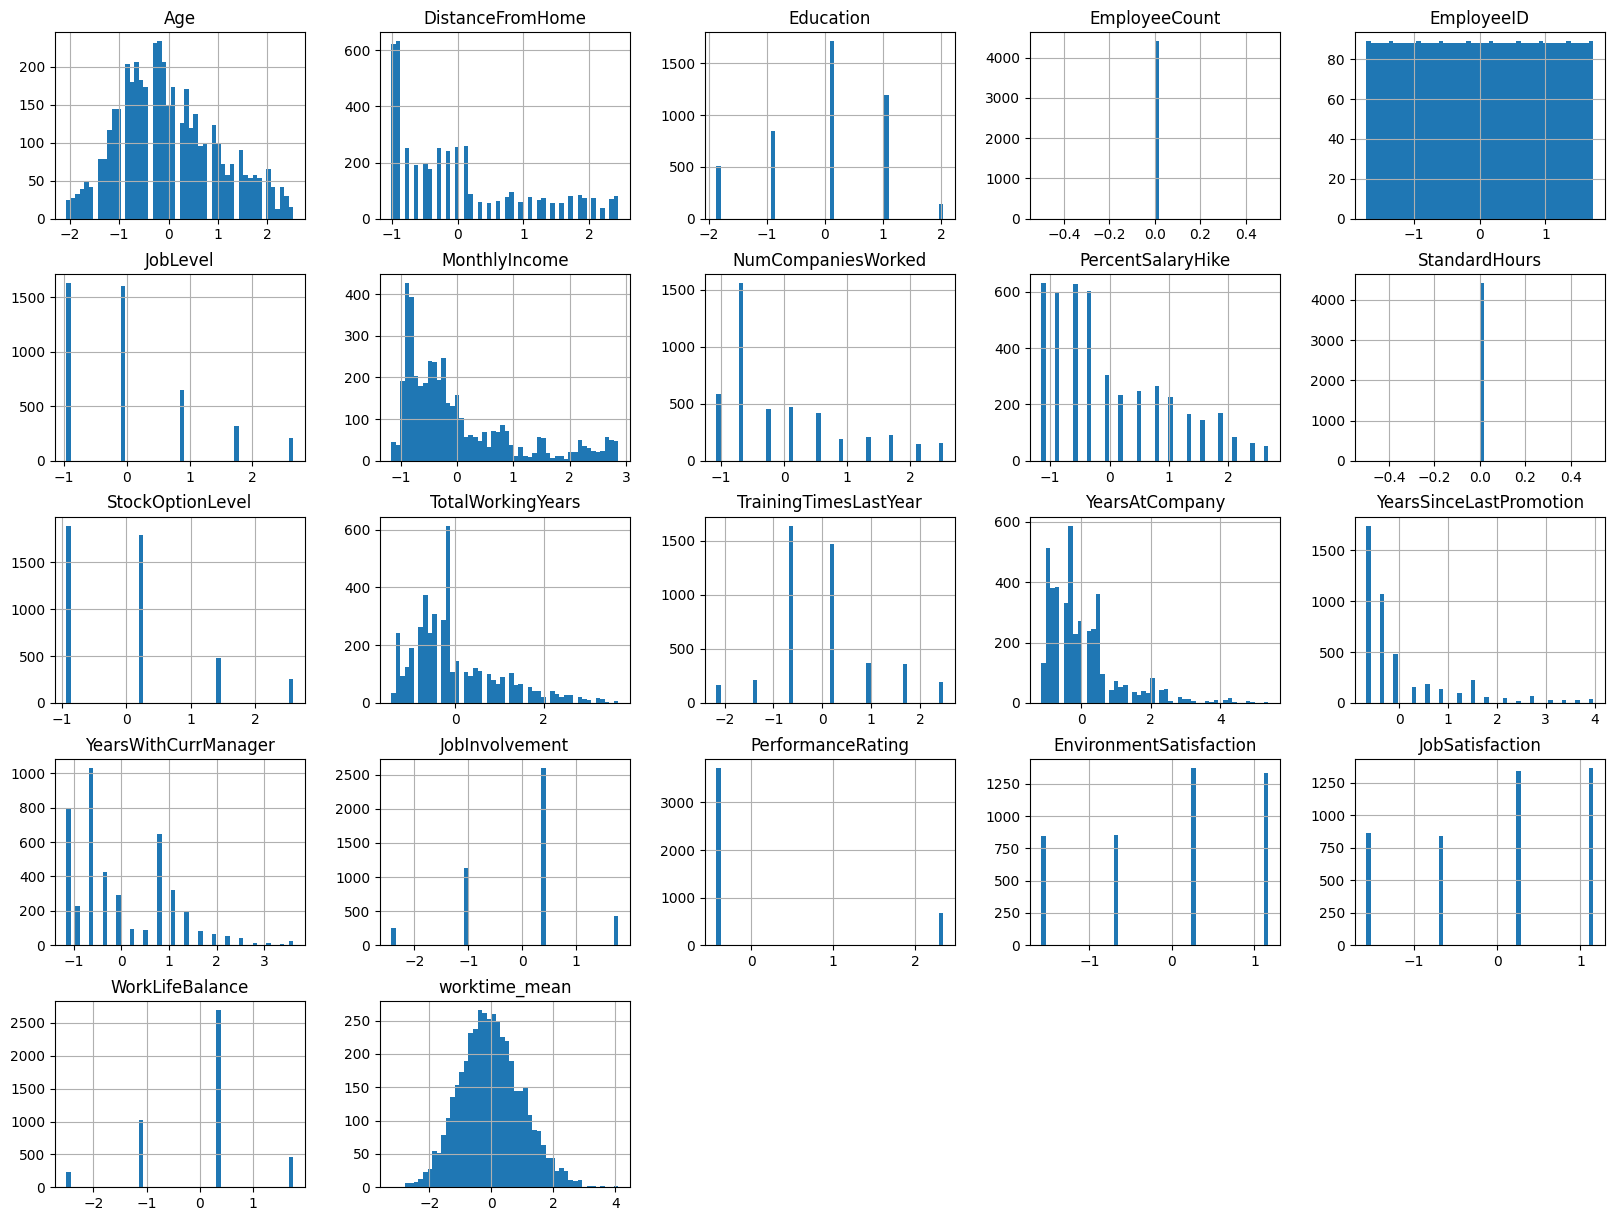

In [20]:
result_final_scaled.hist(bins=50, figsize=(20,15))
plt.show()

# 2. Matrice de corrélation

# 3. Sélection des variables pour le modèle

## 3.1 Définition de la variable cible et les variables pour le modèle

In [21]:
y = finalresult["Attrition"]
X = finalresult.drop(columns="Attrition")

## 3.2 Test de dépendance des variables

In [22]:
selecteur = SelectPercentile(f_classif,percentile=50)
selecteur.fit_transform(X, y)

c:\Users\brago\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [ 3  9 48] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\brago\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


array([[ 1.54136892,  1.40513592, -0.6784636 , ...,  0.        ,
         1.        ,  0.        ],
       [-0.64866811, -0.491661  , -1.0794855 , ...,  0.        ,
         0.        ,  1.        ],
       [-0.53916626,  2.72505331, -0.6784636 , ...,  0.        ,
         1.        ,  0.        ],
       ...,
       [-1.30567922, -0.5951381 , -1.0794855 , ...,  0.        ,
         1.        ,  0.        ],
       [ 0.55585225, -0.87221027, -1.0794855 , ...,  1.        ,
         0.        ,  0.        ],
       [ 0.33684855, -0.21990081, -1.0794855 , ...,  1.        ,
         0.        ,  0.        ]])

## 3.3 Sélection des variables

### 3.3.1 On garde la moitié des variables avec la plus grande dépendance avec la target

In [23]:
avant = np.array(X.columns)
reste = np.array(X.columns)[selecteur.get_support()]
print(f"Avant on avait : {len(avant)} colonnes mais maintenant il n'en reste que {len(reste)}")
print(f'\n {reste}')
X = X[reste]

Avant on avait : 49 colonnes mais maintenant il n'en reste que 24

 ['Age' 'MonthlyIncome' 'NumCompaniesWorked' 'PercentSalaryHike'
 'TotalWorkingYears' 'TrainingTimesLastYear' 'YearsAtCompany'
 'YearsSinceLastPromotion' 'YearsWithCurrManager'
 'EnvironmentSatisfaction' 'JobSatisfaction' 'WorkLifeBalance'
 'worktime_mean' 'BusinessTravel_Non-Travel'
 'BusinessTravel_Travel_Frequently' 'BusinessTravel_Travel_Rarely'
 'Department_Human Resources' 'EducationField_Human Resources'
 'EducationField_Technical Degree' 'JobRole_Manufacturing Director'
 'JobRole_Research Director' 'MaritalStatus_Divorced'
 'MaritalStatus_Married' 'MaritalStatus_Single']


#### 3.3.2 On écarte les variables avec une variance inférieure à 0.1

In [39]:
selector = VarianceThreshold(threshold=0.1)
selector.fit_transform(X)
reste = np.array(X.columns)[selector.get_support()]
print(f'il reste {len(reste)} colonnes')
print(f'\n {reste}')
X = X[reste]

il reste 18 colonnes

 ['Age' 'MonthlyIncome' 'NumCompaniesWorked' 'PercentSalaryHike'
 'TotalWorkingYears' 'TrainingTimesLastYear' 'YearsAtCompany'
 'YearsSinceLastPromotion' 'YearsWithCurrManager'
 'EnvironmentSatisfaction' 'JobSatisfaction' 'WorkLifeBalance'
 'worktime_mean' 'BusinessTravel_Travel_Frequently'
 'BusinessTravel_Travel_Rarely' 'MaritalStatus_Divorced'
 'MaritalStatus_Married' 'MaritalStatus_Single']


In [40]:
X.head()

,Age,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,worktime_mean,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single
0,1.541369,1.405136,-0.678464,-1.150554,-1.322079,2.483396,-0.981014,-0.679146,-1.155935,0.252200,1.156302,-1.085336,-1.067289,0.0,1.0,0.0,1.0,0.0
1,-0.648668,-0.491661,-1.079486,2.129306,-0.678877,0.155707,-0.327893,-0.368715,-0.034520,0.252200,-0.663899,1.757749,-0.730393,1.0,0.0,0.0,0.0,1.0
2,-0.539166,2.725053,-0.678464,-0.057267,-0.807517,-0.620189,-0.327893,-0.679146,-0.314873,-0.665460,-0.663899,-2.506879,0.489015,1.0,0.0,0.0,1.0,0.0
3,0.117845,0.386301,0.123580,-1.150554,0.221606,1.707500,0.161947,1.493867,0.245834,1.169861,1.156302,0.336206,-0.855432,0.0,0.0,0.0,1.0,0.0
4,-0.539166,-0.884109,0.524602,-0.877232,-0.292956,-0.620189,-0.164613,-0.679146,-0.034520,1.169861,-1.573999,0.336206,-0.923552,0.0,1.0,0.0,0.0,1.0
